# Check lib versions

In [40]:
%%bash
# Check nvcc version
nvcc -V
echo
# Check GCC version
gcc --version
echo
# Check the version of torch and cuda packages
pip list | grep "torch\|cuda"

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_May__3_18:49:52_PDT_2022
Cuda compilation tools, release 11.7, V11.7.64
Build cuda_11.7.r11.7/compiler.31294372_0

gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.


cuda-python                   11.6.1
cupy-cuda115                  9.6.0
dask-cuda                     22.4.0
nvidia-dali-cuda110           1.13.0
pytorch-quantization          2.1.2
torch                         1.12.0a0+8a1a93a
torch-tensorrt                1.1.0a0
torchtext                     0.13.0a0
torchvision                   0.13.0a0


# Setup Weights & Biases

In [41]:
# !pip install -q --upgrade wandb


# import os
# os.environ["WANDB_NOTEBOOK_NAME"] = "pigtracking_prediction.ipynb"
# import wandb
# wandb.login()

# wandb.__version__

In [42]:
# import wandb
# import os

# os.environ["WANDB_NOTEBOOK_NAME"] = "mmdetecttion_custom_dataset"

# wandb.init(project="animaltracking", entity="mjirik")

In [43]:
# Some basic setup


import sys
from pathlib import Path

sys.path.insert(0, str(Path(".").absolute().parent.absolute()))

# import some common libraries
import logging
import mmcv.utils

logger = mmcv.utils.get_logger(name="general_logger", log_level=logging.DEBUG)

import matplotlib.pyplot as plt
import numpy as np

# Check Pytorch installation
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet

logger.debug(f"mmdet.version={mmdet.__version__}")

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

logger.debug(get_compiling_cuda_version())
logger.debug(get_compiler_version())
from pprint import pprint, pformat
from mmdet.datasets import build_dataset
from mmdet.apis import train_detector
from mmcv import Config
from mmdet.apis import set_random_seed
from pathlib import Path
import os.path as osp
import os
import mmcv
from mmcv.runner import load_checkpoint
from typing import Optional

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import skimage
import random
from pathlib import Path
import cv2
import json

%load_ext autoreload
%autoreload 2
import visualization

2023-01-05 17:29:16,994 - general_logger - DEBUG - mmdet.version=2.25.0
2023-01-05 17:29:16,995 - general_logger - DEBUG - 11.7
2023-01-05 17:29:16,996 - general_logger - DEBUG - GCC 9.4


1.12.0a0+8a1a93a True
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
mmdet.__version__

'2.25.0'

# Prepare data

Download and copy dataset to scratch dir.

In [45]:
scratchdir = Path(os.getenv("SCRATCHDIR", "."))
logname = Path(os.getenv("LOGNAME", "."))
# from loguru import logger

# input_dirs = list(Path(
#     "/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/"
# ).glob("20*"))


# local_input_data_dir = Path(scratchdir) / "data/orig/"
local_output_data_dir = Path(scratchdir) / "data/processed/"

# Set input path to videos

In [118]:
# mask_pth = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/cam1_mask2.png")
pixelsize_cm = 0.2
mask_pth = Path(
    "/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/cam2_mask1.png"
)
pixelsize_cm = 0.2

# last generated
input_dir = sorted(
    list(
        Path(
            "/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/"
        ).glob("20*/*.mp4")
    )
)[-1].parent

# Sample
# input_dir = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/zverinec-top-view")
input_dir

PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/20230105_171131')

In [122]:
fns = sorted(list(Path(input_dir).glob("*.mp4")))
fn = fns[0]
fns

[PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/20230105_171131/cam1-00000-00600.mp4'),
 PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/20230105_171131/cam1-00600-01200.mp4'),
 PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/20230105_171131/cam1-01200-01800.mp4'),
 PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/20230105_171131/cam1-01800-02400.mp4'),
 PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/20230105_171131/cam1-02400-03000.mp4'),
 PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/20230105_171131/cam1-03000-03600.mp4'),
 PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/20230105_171131/cam1-03600-04200.mp4'),
 PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/20230105_171131/cam1-04200-04800.mp4')]

In [71]:
# !mkdir -p ~/data/orig/cocos2d
# # !cd ~/data/orig/cocos2d
# !wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip -O data.zip
# !unzip -o data.zip -d "$SCRATCHDIR"/data/orig/cocos2d > /dev/null
# !pwd

In [72]:
# !ls ~/data/orig/cocos2d

In [73]:
!echo "$SCRATCHDIR"

/scratch/mjirik/job_13862697.meta-pbs.metacentrum.cz


In [74]:
# !mkdir -p "$SCRATCHDIR"/data/orig
# # !cp -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/* "$SCRATCHDIR"/data/orig
# !cp -r /storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/pigtracking.zip "$SCRATCHDIR"/data/orig
# !unzip -o "$SCRATCHDIR"/data/orig/pigtracking.zip -d "$SCRATCHDIR"/data/orig > /dev/null
# !ls "$SCRATCHDIR"/data/orig

In [75]:
# !ls "$SCRATCHDIR"/data/orig

In [76]:
# import animaltracking.coco_dataset
# fnin = local_input_data_dir / 'annotations/instances_default.json'
# fn1 = local_input_data_dir / 'annotations/train.json'
# fn2 = local_input_data_dir / 'annotations/test.json'
# fn3 = local_input_data_dir / 'annotations/val.json'
# fntmp = local_input_data_dir / 'annotations/tmp.json'
# ccd = animaltracking.coco_dataset.CocoDataset(fnin, local_input_data_dir / "images")
# ccd.train_test_split(fn1, fntmp)
# ccd = animaltracking.coco_dataset.CocoDataset(fntmp, local_input_data_dir / "images")
# ccd.train_test_split(fn2, fn3, 0.5)
# fn3.exists()

# Prepare checkpoint

In [77]:
import requests
import tqdm
from mmdet.apis import init_detector, inference_detector
import mmcv
from matplotlib import pyplot as plt

In [78]:
mmdetection_path = Path(mmdet.__file__).parent.parent


# logger.debug(f"outputdir={local_output_data_dir}")
# logger.debug(f"input_data_dir={local_input_data_dir}")
# logger.debug(f"input_data_dir exists={local_input_data_dir.exists()}")
# logger.debug(f'input_data_dir glob={str(list(local_input_data_dir.glob("**/*")))}')

# Choose to use a config and initialize the detector
config_file = Path(
    mmdetection_path
    / "configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py"
)
logger.debug(f"config.exists={config_file.exists()}")
# Setup a checkpoint file to load
checkpoint_file = Path(
    "/storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/tutorial_exps/latest.pth"
)
logger.debug(f"checkpoint_pth.exists={checkpoint_file.exists()}")

# Set the device to be used for evaluation
device = "cuda:0"

config = mmcv.Config.fromfile(config_file)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None
config.model.roi_head.bbox_head.num_classes = 1

model = init_detector(config, str(checkpoint_file), device=device)

# or save the visualization results to image files
# model.show_result(img, result, out_file='result.jpg')

2023-01-05 17:36:50,860 - general_logger - DEBUG - config.exists=True
2023-01-05 17:36:50,863 - general_logger - DEBUG - checkpoint_pth.exists=True


load checkpoint from local path: /storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/tutorial_exps/latest.pth


## Test model on one image

In [79]:
# # test a single image and show the results
# img_pth = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/images/frame_036987.PNG")
# # img = 'test.jpg'  # or img = mmcv.imread(img), which will only load it once
# result = inference_detector(model, img_pth)
# # visualize the results in a new window
# plt.imshow(model.show_result(img_pth, result))

## Test mask algorithm

In [80]:
class Masker:
    def __init__(self, mask_pth: Path):

        mask = skimage.io.imread(mask_pth, as_gray=True)
        mask = (mask > (0.5 * np.max(mask))).astype(float)
        self.mask3 = np.repeat(mask[:, :, np.newaxis], repeats=3, axis=2)

    def do_mask(self, img):
        tp = img.dtype
        return (img * self.mask3).astype(tp)


# mask_pth = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/cam1_mask2.png")
# ms = Masker(mask_pth)
# # mask3.shape
# im_masked = ms.do_mask(skimage.io.imread(img_pth))
# plt.imshow(im_masked)

# Process video

### Test one frame mask and detection

[h264 @ 0x5639d6fb7bc0] sps_id 0 out of range
[h264 @ 0x5639d6fb7bc0] sps_id 0 out of range
[h264 @ 0x5639d6fb7bc0] non-existing PPS 0 referenced
[h264 @ 0x5639d6fb7bc0] decode_slice_header error
[h264 @ 0x5639d6fb7bc0] no frame!
[h264 @ 0x5639d6fb7bc0] non-existing PPS 0 referenced
[h264 @ 0x5639d6fb7bc0] decode_slice_header error
[h264 @ 0x5639d6fb7bc0] no frame!
[h264 @ 0x5639d6fb7bc0] non-existing PPS 0 referenced
[h264 @ 0x5639d6fb7bc0] decode_slice_header error
[h264 @ 0x5639d6fb7bc0] no frame!
[h264 @ 0x5639d6fb7bc0] no frame!
[h264 @ 0x5639d6fb7bc0] no frame!
[h264 @ 0x5639d6fb7bc0] no frame!
[h264 @ 0x5639d8f11c00] sps_id 0 out of range
[h264 @ 0x5639d8f11c00] sps_id 0 out of range
[h264 @ 0x5639d8f11c00] non-existing PPS 0 referenced
[h264 @ 0x5639d8f11c00] decode_slice_header error
[h264 @ 0x5639d8f11c00] no frame!
[h264 @ 0x5639d5bf8dc0] non-existing PPS 0 referenced
[h264 @ 0x5639d5bf8dc0] decode_slice_header error
[h264 @ 0x5639d5bf8dc0] no frame!
[h264 @ 0x5639d8ae8bc0] 

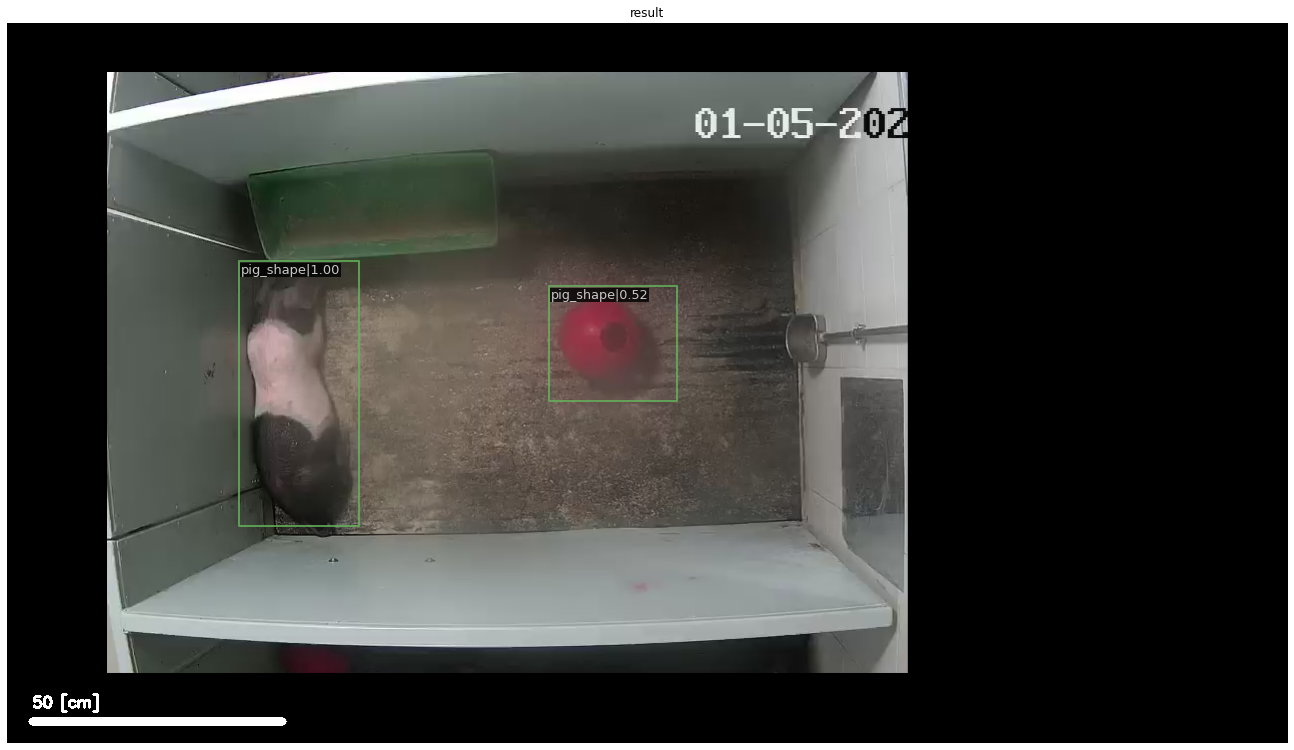

In [180]:
# do the checks
cap = cv2.VideoCapture(str(fn))
ms = Masker(mask_pth)
frame = None
while cap.isOpened():
    # pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
    flag, frame = cap.read()
    if flag and frame is not None:
        result = inference_detector(model, ms.do_mask(frame)[..., ::1])
        # imout = model.show_result(frame, result)
        show_result_pyplot(
            model,
            visualization.insert_ruler_in_image(
                ms.do_mask(frame)[..., ::1], pixelsize_cm, 50, unit="cm"
            ),
            result,
        )
        break
        # video_writer.write(imout)

cap.release()

(720, 1280, 3)

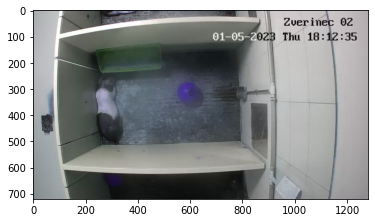

In [181]:
plt.imshow(frame)
frame.shape

### Process whole video

In [103]:
import json
from json import JSONEncoder
import numpy


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [173]:
def get_video_writer(cap, filename):
    # output video
    filename = Path(filename)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    size_input_video = [
        int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    ]

    size_output_video = size_input_video.copy()
    # size_output_video[1] *= 2
    logger.debug(f"{size_input_video}, {size_output_video}")
    # fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fourcc = cv2.VideoWriter_fourcc(*"MJPG")
    # video_name = '{}/pigleg_results.avi'.format(outputdir)
    videoWriter = cv2.VideoWriter(
        str(filename.with_suffix(".avi")), fourcc, fps, size_output_video
    )
    print(f"{size_output_video=}")
    print(f"{fps=}")
    return videoWriter


def track_in_one_video(
    fn: Path,
    step=10,
    output_dir: Optional[Path] = None,
    threshold: Optional[float] = None,
):

    if output_dir is None:
        output_dir = Path(
            f"/storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/{fn.parent.name}"
        )
    # mask_pth = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/cam1_mask2.png")

    cap = cv2.VideoCapture(str(fn))
    ms = Masker(mask_pth)

    output_fn = output_dir / fn.name
    video_writer = get_video_writer(cap, str(output_fn))

    output_dir.mkdir(exist_ok=True, parents=True)

    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration = length / fps
    results = {
        "bboxes": [],
        "frame": [],
        "datetime": str(datetime.datetime.fromtimestamp(fn.stat().st_mtime)),
        "duration": duration,
        "fps": fps,
    }

    count = 0
    failed = 0

    # length = 1000
    pbar = tqdm.tqdm(desc=fn.name, total=length)
    while cap.isOpened():
        # pos_frame = cap.get(cv2.CAP_PROP_POS_FRAMES)
        count += 1
        pbar.update(1)
        flag, frame = cap.read()
        if ((count - 1) % step) == 0:
            if flag and frame is not None:
                result = inference_detector(model, ms.do_mask(frame)[..., ::-1])
                # result = inference_detector(model, frame[...,::-1])
                bboxes = result[0]

                if threshold:
                    bboxes = bboxes[bboxes[:, 4] > threshold, :]

                imout = visualization.insert_ruler_in_image(
                    ms.do_mask(frame.copy())[..., ::1], pixelsize_cm, 50, unit="cm"
                )
                imout = model.show_result(frame, result)
                video_writer.write(imout)

                results["bboxes"].append(bboxes)
                # results["bbox1"].append(bboxes[0][1])
                # results["bbox2"].append(bboxes[0][2])
                # results["bbox3"].append(bboxes[0][3])
                # results["prob"].append(bboxes[0][4])
                # results["obj_id"].append(0)
                # results["cls"].append(0)
                results["frame"].append(count)

            else:
                failed += 1
                # print(f"{failed}/{count}")
        if count > length:
            break
    cap.release()
    video_writer.release()
    with open(output_fn.with_suffix(".results.json"), "w") as f:
        json.dump(results, f, cls=NumpyArrayEncoder)

    if frame is not None:
        cv2.imwrite(str(output_fn.with_suffix(".jpg")), frame)
    if imout is not None:
        cv2.imwrite(str(output_fn.with_suffix(".labeled.jpg")), imout)
    return frame

    # frame.shape
    # plt.imshow(frame)

In [174]:
for fn in fns:
    track_in_one_video(fn, threshold=0.5, step=1000)

[h264 @ 0x563a717aed40] sps_id 0 out of range
[h264 @ 0x563a717aed40] sps_id 0 out of range
[h264 @ 0x563a717aed40] no frame!
[h264 @ 0x563a717aed40] no frame!
[h264 @ 0x563a717aed40] no frame!
[h264 @ 0x5639d65f3d80] sps_id 0 out of range
[h264 @ 0x5639d65f3d80] sps_id 0 out of range
2023-01-05 19:19:15,929 - general_logger - DEBUG - [1280, 720], [1280, 720]


size_output_video=[1280, 720]
fps=15





cam1-00000-00600.mp4:   0%|          | 0/12738 [00:00<?, ?it/s][h264 @ 0x5639d65f3d80] no frame!
[h264 @ 0x5639dde66dc0] no frame!
[h264 @ 0x5639dc780600] no frame!
[h264 @ 0x5639dc7d5300] no frame!
[h264 @ 0x563a5cd0e080] no frame!
[h264 @ 0x563a5cd26c00] no frame!
[h264 @ 0x563a3d2562c0] no frame!
[h264 @ 0x563ab05514c0] no frame!
[h264 @ 0x5639d8f15280] no frame!



cam1-00000-00600.mp4:   1%|          | 64/12738 [00:00<00:20, 633.54it/s][h264 @ 0x563a804df740] no frame!
[h264 @ 0x563a95120940] no frame!
[h264 @ 0x5639d57faa80] no frame!
[h264 @ 0x5639dc781a80] no frame!
[h264 @ 0x5639dc7d5300] no frame!
[h264 @ 0x563a5cd0e080] no frame!



cam1-00000-00600.mp4:   1%|          | 156/12738 [00:00<00:15, 799.59it/s][h264 @ 0x563a86fb56c0] no frame!
[h264 @ 0x563a3d2562c0] no frame!
[h264 @ 0x563ab05514c0] no frame!
[h264 @ 0x563a99595f80] no frame!
[h264 @ 0x563a804df740] no frame!
[h264 @ 0x563a95120940] no frame!



cam1-00000-00600.mp4:   2%|▏         | 252/12738 [00:00<00:14, 8

size_output_video=[1280, 720]
fps=15





cam1-00600-01200.mp4:   0%|          | 0/12733 [00:00<?, ?it/s][h264 @ 0x563a502eb4c0] non-existing PPS 0 referenced
[h264 @ 0x563a502eb4c0] decode_slice_header error
[h264 @ 0x563a502eb4c0] no frame!
[h264 @ 0x563a502b3780] non-existing PPS 0 referenced
[h264 @ 0x563a502b3780] decode_slice_header error
[h264 @ 0x563a502b3780] no frame!
[h264 @ 0x563a5cdb8680] non-existing PPS 0 referenced
[h264 @ 0x563a5cdb8680] decode_slice_header error
[h264 @ 0x563a5cdb8680] no frame!
[h264 @ 0x563a5cd47780] non-existing PPS 0 referenced
[h264 @ 0x563a5cd47780] decode_slice_header error
[h264 @ 0x563a5cd47780] no frame!
[h264 @ 0x563a5cd26c00] non-existing PPS 0 referenced
[h264 @ 0x563a5cd26c00] decode_slice_header error
[h264 @ 0x563a5cd26c00] no frame!
[h264 @ 0x563a5cd0e080] non-existing PPS 0 referenced
[h264 @ 0x563a5cd0e080] decode_slice_header error
[h264 @ 0x563a5cd0e080] no frame!
[h264 @ 0x5639dc781a80] non-existing PPS 0 referenced
[h264 @ 0x5639dc781a80] decode_slice_header error
[h

size_output_video=[1280, 720]
fps=15





cam1-01200-01800.mp4:   0%|          | 0/12735 [00:00<?, ?it/s][h264 @ 0x563a4543b540] non-existing PPS 0 referenced
[h264 @ 0x563a4543b540] decode_slice_header error
[h264 @ 0x563a4543b540] no frame!
[h264 @ 0x5639dc781a80] non-existing PPS 0 referenced
[h264 @ 0x5639dc781a80] decode_slice_header error
[h264 @ 0x5639dc781a80] no frame!
[h264 @ 0x563a5cd47780] non-existing PPS 0 referenced
[h264 @ 0x563a5cd47780] decode_slice_header error
[h264 @ 0x563a5cd47780] no frame!
[h264 @ 0x563a502b3780] non-existing PPS 0 referenced
[h264 @ 0x563a502b3780] decode_slice_header error
[h264 @ 0x563a502b3780] no frame!
[h264 @ 0x563a502eb4c0] non-existing PPS 0 referenced
[h264 @ 0x563a502eb4c0] decode_slice_header error
[h264 @ 0x563a502eb4c0] no frame!
[h264 @ 0x563a3ba2d180] non-existing PPS 0 referenced
[h264 @ 0x563a3ba2d180] decode_slice_header error
[h264 @ 0x563a3ba2d180] no frame!
[h264 @ 0x563a6666d1c0] non-existing PPS 0 referenced
[h264 @ 0x563a6666d1c0] decode_slice_header error
[h

size_output_video=[1280, 720]
fps=15





cam1-01800-02400.mp4:   0%|          | 0/12736 [00:00<?, ?it/s][h264 @ 0x563a5cd47780] non-existing PPS 0 referenced
[h264 @ 0x563a5cd47780] decode_slice_header error
[h264 @ 0x563a5cd47780] no frame!
[h264 @ 0x5639dc781a80] non-existing PPS 0 referenced
[h264 @ 0x5639dc781a80] decode_slice_header error
[h264 @ 0x5639dc781a80] no frame!
[h264 @ 0x563a4543b540] non-existing PPS 0 referenced
[h264 @ 0x563a4543b540] decode_slice_header error
[h264 @ 0x563a4543b540] no frame!
[h264 @ 0x563a6666d1c0] non-existing PPS 0 referenced
[h264 @ 0x563a6666d1c0] decode_slice_header error
[h264 @ 0x563a6666d1c0] no frame!
[h264 @ 0x563a86fb56c0] non-existing PPS 0 referenced
[h264 @ 0x563a86fb56c0] decode_slice_header error
[h264 @ 0x563a86fb56c0] no frame!
[h264 @ 0x563a3d2562c0] non-existing PPS 0 referenced
[h264 @ 0x563a3d2562c0] decode_slice_header error
[h264 @ 0x563a3d2562c0] no frame!
[h264 @ 0x5639d8b50580] no frame!
[h264 @ 0x563a6dde7ec0] no frame!
[h264 @ 0x563a55366400] no frame!
[h26

size_output_video=[1280, 720]
fps=15





cam1-02400-03000.mp4:   0%|          | 0/12738 [00:00<?, ?it/s][h264 @ 0x563a5cd47780] non-existing PPS 0 referenced
[h264 @ 0x563a5cd47780] decode_slice_header error
[h264 @ 0x563a5cd47780] no frame!
[h264 @ 0x563a84b58280] non-existing PPS 0 referenced
[h264 @ 0x563a84b58280] decode_slice_header error
[h264 @ 0x563a84b58280] no frame!
[h264 @ 0x563a84be7500] non-existing PPS 0 referenced
[h264 @ 0x563a84be7500] decode_slice_header error
[h264 @ 0x563a84be7500] no frame!
[h264 @ 0x563a6666d1c0] non-existing PPS 0 referenced
[h264 @ 0x563a6666d1c0] decode_slice_header error
[h264 @ 0x563a6666d1c0] no frame!
[h264 @ 0x563a86fb56c0] non-existing PPS 0 referenced
[h264 @ 0x563a86fb56c0] decode_slice_header error
[h264 @ 0x563a86fb56c0] no frame!
[h264 @ 0x563a3d2562c0] non-existing PPS 0 referenced
[h264 @ 0x563a3d2562c0] decode_slice_header error
[h264 @ 0x563a3d2562c0] no frame!
[h264 @ 0x5639d8b50580] no frame!
[h264 @ 0x563a6dde7ec0] no frame!
[h264 @ 0x563a55366400] no frame!
[h26

size_output_video=[1280, 720]
fps=15





cam1-03000-03600.mp4:   0%|          | 0/12743 [00:00<?, ?it/s][h264 @ 0x563a5cd47780] non-existing PPS 0 referenced
[h264 @ 0x563a5cd47780] decode_slice_header error
[h264 @ 0x563a5cd47780] no frame!
[h264 @ 0x563a3d1aacc0] non-existing PPS 0 referenced
[h264 @ 0x563a3d1aacc0] decode_slice_header error
[h264 @ 0x563a3d1aacc0] no frame!
[h264 @ 0x563a86fb56c0] non-existing PPS 0 referenced
[h264 @ 0x563a86fb56c0] decode_slice_header error
[h264 @ 0x563a86fb56c0] no frame!
[h264 @ 0x563a3d2562c0] non-existing PPS 0 referenced
[h264 @ 0x563a3d2562c0] decode_slice_header error
[h264 @ 0x563a3d2562c0] no frame!
[h264 @ 0x5639d8b50580] non-existing PPS 0 referenced
[h264 @ 0x5639d8b50580] decode_slice_header error
[h264 @ 0x5639d8b50580] no frame!
[h264 @ 0x563a6dde7ec0] non-existing PPS 0 referenced
[h264 @ 0x563a6dde7ec0] decode_slice_header error
[h264 @ 0x563a6dde7ec0] no frame!
[h264 @ 0x563a55366400] non-existing PPS 0 referenced
[h264 @ 0x563a55366400] decode_slice_header error
[h

size_output_video=[1280, 720]
fps=15





cam1-03600-04200.mp4:   0%|          | 0/12742 [00:00<?, ?it/s][h264 @ 0x563a3d1aacc0] non-existing PPS 0 referenced
[h264 @ 0x563a3d1aacc0] decode_slice_header error
[h264 @ 0x563a3d1aacc0] no frame!
[h264 @ 0x563a86fb56c0] non-existing PPS 0 referenced
[h264 @ 0x563a86fb56c0] decode_slice_header error
[h264 @ 0x563a86fb56c0] no frame!
[h264 @ 0x563a3d2562c0] non-existing PPS 0 referenced
[h264 @ 0x563a3d2562c0] decode_slice_header error
[h264 @ 0x563a3d2562c0] no frame!
[h264 @ 0x5639d8b50580] non-existing PPS 0 referenced
[h264 @ 0x5639d8b50580] decode_slice_header error
[h264 @ 0x5639d8b50580] no frame!
[h264 @ 0x563a6dde7ec0] non-existing PPS 0 referenced
[h264 @ 0x563a6dde7ec0] decode_slice_header error
[h264 @ 0x563a6dde7ec0] no frame!
[h264 @ 0x563a55366400] non-existing PPS 0 referenced
[h264 @ 0x563a55366400] decode_slice_header error
[h264 @ 0x563a55366400] no frame!
[h264 @ 0x5639d7cd8780] non-existing PPS 0 referenced
[h264 @ 0x5639d7cd8780] decode_slice_header error
[h

size_output_video=[1280, 720]
fps=15



cam1-04200-04800.mp4:   0%|          | 0/12724 [00:00<?, ?it/s][h264 @ 0x5639dad45f40] non-existing PPS 0 referenced
[h264 @ 0x5639dad45f40] decode_slice_header error
[h264 @ 0x5639dad45f40] no frame!
[h264 @ 0x563a6dd1ac00] non-existing PPS 0 referenced
[h264 @ 0x563a6dd1ac00] decode_slice_header error
[h264 @ 0x563a6dd1ac00] no frame!
[h264 @ 0x563a3d1aacc0] non-existing PPS 0 referenced
[h264 @ 0x563a3d1aacc0] decode_slice_header error
[h264 @ 0x563a3d1aacc0] no frame!
[h264 @ 0x563a70d49500] no frame!
[h264 @ 0x563a3b9b1e40] no frame!
[h264 @ 0x563a54cee680] no frame!
[h264 @ 0x5639d58bcb40] no frame!
[h264 @ 0x563a666d58c0] no frame!
[h264 @ 0x563a70d4c500] no frame!

cam1-04200-04800.mp4:   1%|          | 68/12724 [00:00<00:18, 676.09it/s][h264 @ 0x5639d6fe51c0] no frame!
[h264 @ 0x5639d8d5be80] no frame!
[h264 @ 0x563a92102600] no frame!
[h264 @ 0x563a3d1aacc0] no frame!
[h264 @ 0x563a70d49500] no frame!
[h264 @ 0x563a3b9b1e40] no frame!

cam1-04200-04800.mp4:   1%|▏         | 

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(
/opt/conda

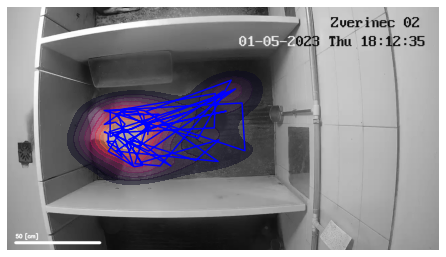

In [190]:
output_dir = Path(
    f"/storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/{input_dir.name}"
)
xx = []
yy = []
datetimes = []
durations = []
for fn in fns:
    output_fn = output_dir / fn.name
    with open(output_fn.with_suffix(".results.json"), "r") as f:
        results = json.load(f)
    for framei, bboxes in zip(results["frame"], results["bboxes"]):
        if len(bboxes) > 0:
            xx.append(np.mean([bboxes[0][0], bboxes[0][2]]))
            yy.append(np.mean([bboxes[0][1], bboxes[0][3]]))

    points = np.asarray([xx, yy]).T
    points.shape
    visualization.create_heatmap_report(points, frame, output_fn.with_suffix(".jpg"))
    datetimes.append(results["datetime"])
    durations.append(results["duration"])
points = np.asarray([xx, yy]).T
points.shape
report_img = visualization.create_heatmap_report(
    points, frame, output_dir / "heatmap.jpg"
)
report_img

In [27]:
list(output_fn.glob("*"))

[]

In [32]:
list(output_fn.parent.glob("*"))

[PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/20230105_140016/cam1-02400-03000.results.json'),
 PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/20230105_140016/cam1-01200-01800.avi'),
 PosixPath('/storage/plzen4-ntis/projects/korpusy_cv/biomedical/processed/pigtracking/20230105_140016/cam1-01200-01800.results.json')]

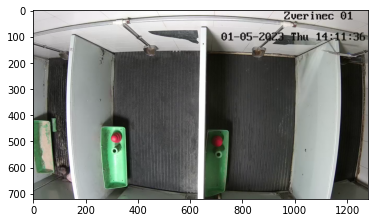

In [38]:
plt.imshow(frame[..., ::-1])

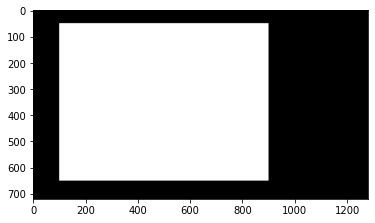

In [68]:
# create the mask

# mask = np.zeros(frame.shape, dtype=np.uint8)
# mask[50:650,100:900] = 255
# # mask = np.zeros(frame.copy())
# plt.imshow(mask)
# mask_pth = Path("/storage/plzen4-ntis/projects/korpusy_cv/biomedical/orig/pigtracking/cam2_mask1.png")
# cv2.imwrite(str(mask_pth), mask)

True

# Prepare report image

In [191]:
pts_cm = points * pixelsize_cm
pts_cm_diff = pts_cm[1:] - pts_cm[:-1]
total_trajectory_length_m = np.sum(np.linalg.norm(pts_cm_diff, axis=1)) * 0.01
total_trajectory_length_m

17.839566768922843

In [194]:
datetimes

['2023-01-05 17:21:38.642622',
 '2023-01-05 17:31:38.662378',
 '2023-01-05 17:41:38.678206',
 '2023-01-05 17:51:38.697969',
 '2023-01-05 18:01:38.757723',
 '2023-01-05 18:11:38.769394',
 '2023-01-05 18:21:38.792989',
 '2023-01-05 18:31:38.812648']

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


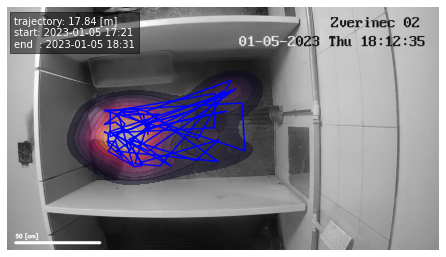

In [214]:
report_fn = output_dir / "report.png"
report_frame = visualization.insert_ruler_in_image(frame, pixelsize_cm, 50, unit="cm")
report_fig = visualization.create_heatmap_report(
    points, report_frame, show_trajectory=True
)
report_fig
t = plt.text(
    20,
    120,
    f"trajectory: {total_trajectory_length_m:.2f} [m]\nstart: {datetimes[0][:16]}\nend  : {datetimes[-1][:16]}",
    c="w",
)
t.set_bbox(dict(facecolor="black", alpha=0.5, edgecolor="black"))
# t = plt.text(10,70, f"start: {datetimes[0][:16]}", c="g")
# t.set_bbox(dict(facecolor='black', alpha=0.5, edgecolor='black'))
# t = plt.text(10,100, f"end  : {datetimes[-1][:16]}", c="g")
# t.set_bbox(dict(facecolor='black', alpha=0.5, edgecolor='black'))

plt.savefig(report_fn, bbox_inches="tight", pad_inches=0)
plt.savefig("report.png", bbox_inches="tight", pad_inches=0)
# plt.close(report_fig)